<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and Functions

In [36]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d aakaashjois/jester-collaborative-filtering-dataset
    !unzip /content/jester-collaborative-filtering-dataset.zip
  else:
    print("Dataset already exists")

#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

#Lets make an anova test to see if this much category is needed
def barplots(dataframe, label, target):
    from scipy import stats
    """
    Takes dataframe, feature and target as parameter
    Applies t-tests for categorical features
    Returns a barpot with t-stat and p values"""
    ttests = []
    string = "Categories  t stat  p value \n "
    if pd.api.types.is_numeric_dtype(dataframe[label]) == False and len(dataframe[label].unique()) <= 20 and len(dataframe[label].unique())>=2:
        e_types = dataframe[label].unique()
        for i, e in enumerate(e_types):
            for i2, e2 in enumerate(e_types):
                if i2 >= i :
                    g1 = dataframe[dataframe[label] == e][target]
                    g2 = dataframe[dataframe[label] == e2][target]
                    t, p = stats.ttest_ind(g1,g2)
                    ttests.append([f"{e} - {e2}", t, p])
                    string += (f"{e} - {e2}: {t:.4f}, {p:.5f} " + " \n ")
                    if p < 0.05:
                        string += "Significant" + "\n"
                    else:
                        string += "Not Significant" + "\n"
        plt.figure()
        plt.figsize=(10,6)
        plt.text(5, 0.1, string, fontsize = 8)
        viz = sns.barplot(data = dataframe, x = label , y = target,)
        viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
        viz.set(title = f"{target} by {label}")
        plt.show()

#To start visualizing data, lets first see the best features in terms of explainin the variance of target
def correlation(dataframe, target):
    from scipy import stats
    """
    Takes dataframe and target feature as parameter
    Returns the correlation between numeric columns and target"""

    output_dataframe = pd.DataFrame(columns = ["Columns","P-Value","Correlation Coefficient(r)","Absolute r"])
    for col in dataframe.drop(target,axis = 1):
        try:
            if pd.api.types.is_numeric_dtype(dataframe[col]):
                r, p = stats.pearsonr(dataframe[col],dataframe[target])
                output_dataframe.loc[col] = [f"{target}-{col}",round(p,4),r,abs(r)]
            else:
                pass
        except:
            pass

    return output_dataframe.sort_values(by = ["Absolute r"],ascending = False)

def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

def categorical_pie(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns pie chart along with value counts"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    dataframe[label].value_counts().plot.pie(autopct = "%1.1f%%")
    plt.subplot(1,2,2)
    sns.countplot(data = dataframe, x = label)

def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)

In [37]:
upload_dataset()

Dataset already exists


# EDA

In [38]:
joke_text_df = pd.read_csv("JokeText.csv", index_col="JokeId")
joke_text_df.head()

,JokeText
JokeId,
0,"A man visits the doctor. The doctor says ""I ha..."
1,This couple had an excellent relationship goin...
2,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,Q. What's the difference between a man and a t...
4,Q.\tWhat's O. J. Simpson's Internet address? \...


In [39]:
user_ratings_1_df = pd.read_csv("UserRatings1.csv",index_col="JokeId")
user_ratings_1_df.head()

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12,User13,User14,User15,User16,User17,User18,User19,User20,User21,User22,User23,User24,User25,User26,User27,User28,User29,User30,User31,User32,User33,User34,User35,User36,User37,User38,User39,User40,User41,User42,User43,User44,User45,User46,User47,User48,User49,User50,...,User36661,User36662,User36663,User36664,User36665,User36666,User36667,User36668,User36669,User36670,User36671,User36672,User36673,User36674,User36675,User36676,User36677,User36678,User36679,User36680,User36681,User36682,User36683,User36684,User36685,User36686,User36687,User36688,User36689,User36690,User36691,User36692,User36693,User36694,User36695,User36696,User36697,User36698,User36699,User36700,User36701,User36702,User36703,User36704,User36705,User36706,User36707,User36708,User36709,User36710
JokeId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,3.06,-9.37,2.28,-1.17,6.75,8.40,7.38,6.07,-0.53,3.40,-7.86,-0.24,-2.86,6.94,9.17,-5.53,5.49,2.09,9.37,-0.87,0.19,-7.57,0.83,-7.96,0.49,-0.78,2.48,-4.03,0.58,-9.37,8.83,-1.41,-2.91,-3.16,8.74,-7.23,2.91,4.22,-2.82,7.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.91,NaN
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,-8.25,9.13,1.75,3.64,8.25,3.16,4.85,3.40,-9.32,8.01,-1.84,1.17,6.07,8.69,7.86,6.55,1.02,1.50,4.17,2.28,4.81,-7.96,-2.48,-6.36,0.24,-4.27,-3.30,-7.77,2.38,6.84,-8.74,-7.04,-4.76,0.87,5.15,-0.39,-9.85,-3.79,-0.63,-2.14,...,NaN,4.37,5.24,NaN,NaN,NaN,NaN,NaN,1.31,NaN,NaN,NaN,NaN,0.83,2.23,NaN,NaN,NaN,-1.80,-7.67,NaN,NaN,NaN,8.64,NaN,NaN,NaN,NaN,-3.06,1.36,NaN,NaN,NaN,NaN,1.99,NaN,NaN,NaN,0.97,5.97,NaN,NaN,NaN,-5.63,NaN,-6.07,NaN,-1.60,-4.56,NaN
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,-3.98,9.27,-9.95,6.50,5.44,7.77,5.39,4.13,-8.74,-2.14,-7.86,1.17,-1.84,2.52,-5.29,5.49,-9.85,-3.64,-9.95,4.13,-1.21,-7.82,4.32,-9.56,4.27,2.82,0.34,1.84,-3.06,2.57,5.92,-3.59,3.06,-1.12,3.16,-5.78,-7.48,8.06,-0.63,5.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.08,NaN,NaN,8.98,NaN
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,-0.58,9.37,-9.47,4.51,1.80,-0.63,4.32,-3.16,-5.29,-8.06,-1.89,-7.91,1.60,1.41,-8.06,1.41,-6.31,-3.30,-3.40,-9.56,-0.19,-1.84,-3.88,-9.37,1.50,-7.62,-2.96,-5.83,-0.15,-9.27,-9.42,-1.21,0.44,-2.48,3.50,-4.03,7.33,-4.95,4.32,-5.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,6.41,9.17,-3.20,5.87,5.68,7.91,-7.62,-9.56,-7.43,6.94,-6.17,7.23,-2.23,-0.39,8.25,1.07,-4.85,1.21,-9.71,1.46,0.63,-4.17,-9.32,1.21,5.15,2.43,2.43,4.66,-4.47,5.73,-3.45,-9.13,-7.52,-5.97,5.00,1.55,5.15,4.76,2.23,-0.87,...,8.4,1.80,-0.78,2.38,-7.86,2.96,0.44,3.88,-0.97,-6.07,-2.72,1.8,-6.46,1.99,0.53,8.69,-6.94,2.67,7.52,-4.03,5.53,6.7,-2.72,0.34,8.59,2.77,-6.21,-0.24,-0.44,2.33,4.9,-8.93,8.74,-4.85,1.89,5.58,-5.05,8.45,-0.49,1.02,2.28,-0.49,5.1,-0.29,-3.54,-1.36,7.48,-5.78,0.73,2.62


In [40]:
user_ratings_2_df = pd.read_csv("UserRatings2.csv",index_col="JokeId")
user_ratings_2_df.head()

,User36711,User36712,User36713,User36714,User36715,User36716,User36717,User36718,User36719,User36720,User36721,User36722,User36723,User36724,User36725,User36726,User36727,User36728,User36729,User36730,User36731,User36732,User36733,User36734,User36735,User36736,User36737,User36738,User36739,User36740,User36741,User36742,User36743,User36744,User36745,User36746,User36747,User36748,User36749,User36750,User36751,User36752,User36753,User36754,User36755,User36756,User36757,User36758,User36759,User36760,...,User73372,User73373,User73374,User73375,User73376,User73377,User73378,User73379,User73380,User73381,User73382,User73383,User73384,User73385,User73386,User73387,User73388,User73389,User73390,User73391,User73392,User73393,User73394,User73395,User73396,User73397,User73398,User73399,User73400,User73401,User73402,User73403,User73404,User73405,User73406,User73407,User73408,User73409,User73410,User73411,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421
JokeId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,3.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.40,NaN,NaN,NaN,NaN,NaN,NaN,5.15,NaN,NaN,NaN,2.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.76,NaN,NaN,NaN,NaN,NaN,-8.01,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.81,NaN,-8.2,NaN,NaN,NaN,NaN,-6.07,NaN,4.56,6.75,NaN,NaN,NaN,3.11,NaN,NaN,NaN,4.47,NaN,NaN,-9.85,NaN,-8.45,NaN,-0.44,-5.29,-2.18,-6.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.58,NaN,NaN,NaN,NaN,NaN,9.32,1.07,NaN,NaN,NaN,1.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.58,NaN,NaN,NaN,NaN,NaN,-8.64,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.68,1.07,8.11,-2.33,-5.83,8.2,-5.83,1.94,0.10,4.81,-8.2,-7.18,-3.3,0.58,4.61,8.93,6.46,-7.57,3.83,7.67,6.21,9.27,4.61,1.55,6.36,-9.37,4.37,-6.5,-9.51,-9.90,7.28,8.93,-6.41,-2.33,2.09,-1.26,8.01,-3.11,5.73,-9.66,-4.42,-0.53,-1.41,8.2,5.58,NaN,3.11,-2.72,5.83,2.62,...,5.58,4.08,5.0,1.41,-5.49,-8.69,0.24,-7.52,3.54,2.77,-8.25,-6.12,2.28,-9.22,6.46,-8.01,-7.48,2.96,8.79,2.91,5.0,5.68,-4.32,0.63,5.63,8.4,2.23,0.97,0.1,6.07,2.96,5.15,6.46,-7.33,-7.48,0.83,-6.17,-1.99,-4.47,-2.86,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3


So we have 73421 user and their emotions on jokes from -10 to 10. There are of course some null values. Here we will try to create a reccomendation model.

## JokeText

In [41]:
joke_text_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   JokeText  100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


We have 100 jokes corresponding to rows in ratings dataframe. And there seems no null value, lets check any duplicate and then move on to users df.

In [42]:
joke_text_df.duplicated().sum()

0

Perfect!

## User Ratings

In [43]:
df_ratings = pd.concat([user_ratings_1_df,user_ratings_2_df],axis=1)
df_ratings = df_ratings.T
df_ratings.head()

JokeId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
User1,5.10,4.90,1.75,-4.17,5.15,1.75,4.76,3.30,-2.57,-1.41,4.22,0.53,-9.85,-0.53,-9.56,-0.58,-1.89,-0.39,-3.50,4.13,4.13,-3.54,-9.66,4.22,-3.45,-3.93,9.22,1.50,4.90,3.01,-1.70,0.15,4.37,5.63,6.55,9.13,-9.76,3.74,-1.21,4.17,-4.17,-1.07,4.81,2.48,-5.39,-1.99,1.02,9.17,4.13,5.73,1.60,6.31,3.64,6.36,3.35,4.76,1.41,-9.71,-0.63,-4.76,4.51,4.95,0.58,5.63,5.05,2.91,1.41,3.88,-3.64,2.62,-9.66,1.65,7.72,7.96,-6.70,2.33,8.54,7.62,7.82,6.31,3.88,6.55,1.55,3.93,6.50,4.22,9.32,-4.51,1.02,3.88,5.34,-4.61,3.59,7.18,0.92,6.31,-4.95,-0.19,3.25,4.37
User2,-8.79,-0.87,1.99,-4.61,5.39,-0.78,1.60,1.07,-8.69,-4.66,7.72,7.48,2.62,-5.05,1.12,-0.92,0.92,-3.54,-4.42,2.14,6.31,-6.41,-1.31,-4.61,-4.95,4.08,-1.41,0.68,4.95,0.15,5.97,-0.73,1.26,-6.26,3.35,-0.34,4.37,-6.55,-4.85,1.26,-0.97,-2.23,-7.14,-7.86,-2.62,3.79,-3.06,-4.42,5.10,3.59,-4.61,1.17,2.23,5.00,-5.58,-2.62,-9.90,-8.06,-5.58,-7.23,3.50,3.79,1.21,-1.02,-3.93,4.51,-3.98,2.96,3.83,-5.58,-9.95,0.10,0.87,-1.60,1.36,-4.95,-1.75,-1.60,-1.21,3.45,3.69,-1.36,2.77,1.07,1.12,-3.30,2.72,2.09,-2.77,2.82,3.59,1.21,2.86,-0.05,-1.75,-1.02,-0.97,4.13,-1.84,2.96
User3,-3.50,-2.91,-2.18,-0.10,7.52,1.26,-5.39,1.50,-8.40,4.37,3.45,-3.20,-0.58,-1.80,-6.89,-4.61,0.00,-5.78,-6.12,-6.50,-3.59,-0.83,-4.42,-4.76,-3.54,-6.46,5.00,0.78,-2.04,-0.87,4.90,6.17,-3.30,3.20,-2.18,1.46,-5.39,1.75,0.00,6.84,-0.97,-0.68,4.51,-5.19,-4.95,-0.34,-6.55,-2.14,-2.86,4.51,-0.19,1.50,3.79,-1.36,2.62,-1.50,-6.31,-7.91,-2.48,-5.68,0.19,2.33,-3.11,1.80,-0.49,2.72,3.88,-1.17,2.43,-4.71,8.64,-9.42,7.14,-9.47,-4.32,4.56,2.77,6.84,7.14,8.35,3.35,6.36,7.82,-7.67,8.88,-9.66,7.14,-8.79,-8.79,5.05,1.84,-4.03,-1.41,1.65,-3.79,3.98,-6.46,-6.89,-2.33,-7.38
User4,7.14,-3.88,-3.06,0.05,6.26,6.65,-7.52,7.28,-5.15,-7.14,-3.06,7.67,-5.05,4.81,7.33,3.30,-5.58,5.97,-8.25,-7.48,-0.29,-0.87,5.10,-7.18,3.25,5.78,8.59,8.01,8.64,-3.30,-3.16,7.62,-4.47,-3.16,8.01,5.92,7.04,2.48,-5.49,1.46,-5.00,5.44,-6.31,-7.82,7.18,5.63,6.84,-0.53,6.55,8.98,-7.77,-4.56,1.21,6.50,-7.28,8.59,0.29,-9.17,3.59,7.18,3.35,4.66,8.01,8.45,5.39,5.53,-7.82,8.35,7.14,-4.90,3.79,7.04,-8.88,-8.88,-8.11,5.39,-9.13,-7.62,-8.98,-7.38,-2.18,5.00,3.50,1.36,-8.74,-4.03,6.12,1.55,6.21,-4.42,-4.47,6.36,4.71,-5.19,6.26,3.93,-2.57,1.07,2.33,-0.34
User5,-8.79,-0.58,-0.58,8.98,7.67,8.25,4.08,2.52,-9.66,2.48,6.89,1.36,4.90,2.77,6.31,-0.44,2.33,-8.11,-8.40,-2.96,6.80,6.17,-7.14,-9.66,8.50,4.61,5.83,6.41,5.78,2.67,-2.52,7.38,5.83,-7.38,6.02,-4.47,0.68,6.26,-0.34,-0.63,3.25,-9.51,-8.64,8.98,5.63,8.30,8.59,8.20,3.50,9.17,0.53,1.02,3.01,8.11,-0.10,8.50,-9.71,-9.90,6.84,-8.74,8.01,9.03,1.84,0.63,-9.66,6.31,-9.81,6.07,6.89,-7.04,8.20,8.20,2.48,-9.42,8.74,8.74,8.74,3.25,5.24,-0.29,9.08,9.22,5.00,9.22,8.30,8.30,3.98,5.53,4.85,9.13,-0.29,9.37,8.30,9.13,-3.45,9.13,9.17,9.17,9.08,8.98


In [44]:
# Lets drop the dataframes to free RAM
del user_ratings_1_df
del user_ratings_2_df

In [45]:
unistats(df_ratings)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
16,73413,8,401,float64,-0.29,-1.288101,-9.95,-4.71,-0.730,1.8000,9.81,4.439184,0.033585,-0.683595
7,73411,10,400,float64,-0.29,-0.996267,-9.95,-5.19,-0.630,2.7700,9.76,4.968263,0.020730,-0.979035
19,73410,11,402,float64,-0.29,-1.203270,-9.95,-5.58,-0.970,2.7200,9.71,5.158966,0.109763,-0.973549
14,73406,15,400,float64,-0.29,-2.112506,-9.95,-6.60,-2.545,1.8900,9.90,5.123141,0.285198,-0.970141
18,73406,15,404,float64,-0.29,0.171560,-9.95,-3.69,0.630,3.9800,10.00,5.048561,-0.220538,-0.849831
4,73405,16,401,float64,-0.29,0.235352,-9.95,-4.03,0.920,4.3700,9.51,5.302902,-0.246245,-0.980103
12,73405,16,400,float64,-0.29,-1.944859,-9.95,-6.55,-2.140,2.1400,9.76,5.137793,0.200557,-1.031513
17,73404,17,403,float64,-0.29,-0.906163,-9.95,-4.95,-0.490,2.8600,9.81,4.993185,-0.034423,-0.942689
6,73401,20,402,float64,-0.29,-0.633947,-9.95,-5.87,-0.290,3.8800,10.00,5.610902,-0.028549,-1.184126
15,73399,22,399,float64,-9.81,-3.103138,-9.95,-7.48,-3.880,0.6300,9.37,5.028330,0.474494,-0.784644


We have missing data points. Imputing these with random numbers may cause a problem, and we already have enough data points so we move on.

In [46]:
#Best joke
df_ratings.mean().sort_values().tail(1)

JokeId
49    3.362593
dtype: float64

Joke no:49 seems to be the best along with 88. I wondered what are these.

In [47]:
print(joke_text_df.loc[49].values[0])

A guy goes into confession and says to the priest, "Father, I'm 80 years
old, widower, with 11 grandchildren. Last night I met two beautiful flight
attendants. They took me home and I made love to both of them. Twice."

The priest said: "Well, my son, when was the last time you were in
confession?"
 "Never Father, I'm Jewish."
 "So then, why are you telling me?"
 "I'm telling everybody."



An ethnic joke, loved it!

<Axes: ylabel='Count'>

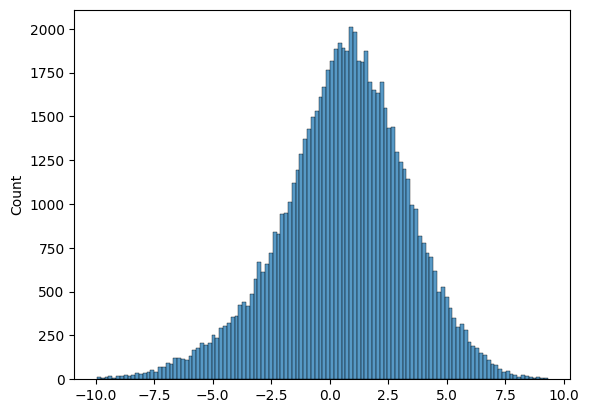

In [48]:
#Lets look at the histogram of means
sns.histplot(df_ratings.mean(axis=1))

The distribution of the average point for jokes are close to standard normal with mean 0 and varianca sigma although it converges in 10 and -10.

In [49]:
# Lets make the ratings as features and jokes in the id column
final_df = df_ratings.T
final_df["joke"] = joke_text_df["JokeText"]
final_df.head()

,User1,User2,User3,User4,User5,User6,User7,User8,User9,User10,User11,User12,User13,User14,User15,User16,User17,User18,User19,User20,User21,User22,User23,User24,User25,User26,User27,User28,User29,User30,User31,User32,User33,User34,User35,User36,User37,User38,User39,User40,User41,User42,User43,User44,User45,User46,User47,User48,User49,User50,...,User73373,User73374,User73375,User73376,User73377,User73378,User73379,User73380,User73381,User73382,User73383,User73384,User73385,User73386,User73387,User73388,User73389,User73390,User73391,User73392,User73393,User73394,User73395,User73396,User73397,User73398,User73399,User73400,User73401,User73402,User73403,User73404,User73405,User73406,User73407,User73408,User73409,User73410,User73411,User73412,User73413,User73414,User73415,User73416,User73417,User73418,User73419,User73420,User73421,joke
JokeId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5.10,-8.79,-3.50,7.14,-8.79,9.22,-4.03,3.11,-3.64,-7.67,3.06,-9.37,2.28,-1.17,6.75,8.40,7.38,6.07,-0.53,3.40,-7.86,-0.24,-2.86,6.94,9.17,-5.53,5.49,2.09,9.37,-0.87,0.19,-7.57,0.83,-7.96,0.49,-0.78,2.48,-4.03,0.58,-9.37,8.83,-1.41,-2.91,-3.16,8.74,-7.23,2.91,4.22,-2.82,7.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"A man visits the doctor. The doctor says ""I ha..."
1,4.90,-0.87,-2.91,-3.88,-0.58,9.37,-1.55,0.92,-3.35,-5.15,-8.25,9.13,1.75,3.64,8.25,3.16,4.85,3.40,-9.32,8.01,-1.84,1.17,6.07,8.69,7.86,6.55,1.02,1.50,4.17,2.28,4.81,-7.96,-2.48,-6.36,0.24,-4.27,-3.30,-7.77,2.38,6.84,-8.74,-7.04,-4.76,0.87,5.15,-0.39,-9.85,-3.79,-0.63,-2.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This couple had an excellent relationship goin...
2,1.75,1.99,-2.18,-3.06,-0.58,-3.93,-3.64,7.52,-6.46,-3.25,-3.98,9.27,-9.95,6.50,5.44,7.77,5.39,4.13,-8.74,-2.14,-7.86,1.17,-1.84,2.52,-5.29,5.49,-9.85,-3.64,-9.95,4.13,-1.21,-7.82,4.32,-9.56,4.27,2.82,0.34,1.84,-3.06,2.57,5.92,-3.59,3.06,-1.12,3.16,-5.78,-7.48,8.06,-0.63,5.53,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q. What's 200 feet long and has 4 teeth? \n\nA...
3,-4.17,-4.61,-0.10,0.05,8.98,9.27,-6.99,0.49,-3.40,-1.65,-0.58,9.37,-9.47,4.51,1.80,-0.63,4.32,-3.16,-5.29,-8.06,-1.89,-7.91,1.60,1.41,-8.06,1.41,-6.31,-3.30,-3.40,-9.56,-0.19,-1.84,-3.88,-9.37,1.50,-7.62,-2.96,-5.83,-0.15,-9.27,-9.42,-1.21,0.44,-2.48,3.50,-4.03,7.33,-4.95,4.32,-5.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Q. What's the difference between a man and a t...
4,5.15,5.39,7.52,6.26,7.67,3.45,5.44,-0.58,1.26,4.03,6.41,9.17,-3.20,5.87,5.68,7.91,-7.62,-9.56,-7.43,6.94,-6.17,7.23,-2.23,-0.39,8.25,1.07,-4.85,1.21,-9.71,1.46,0.63,-4.17,-9.32,1.21,5.15,2.43,2.43,4.66,-4.47,5.73,-3.45,-9.13,-7.52,-5.97,5.00,1.55,5.15,4.76,2.23,-0.87,...,4.08,5.0,1.41,-5.49,-8.69,0.24,-7.52,3.54,2.77,-8.25,-6.12,2.28,-9.22,6.46,-8.01,-7.48,2.96,8.79,2.91,5.0,5.68,-4.32,0.63,5.63,8.4,2.23,0.97,0.1,6.07,2.96,5.15,6.46,-7.33,-7.48,0.83,-6.17,-1.99,-4.47,-2.86,3.64,4.32,6.99,-9.66,-8.4,-0.63,9.51,-7.67,-1.6,8.3,Q.\tWhat's O. J. Simpson's Internet address? \...


# Modelling

## Content Based Filtering w TF-IDF

TF IDF vectorizer is used to help classification of text documents using sparse features. Here we will look at each word in jokes and try to cluster them to reccomend new one to a user.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

TfidfVectorizer helps to take useful words that may help to find similar jokes.

In [51]:
model_tfid = TfidfVectorizer(stop_words="english")
model_tfid.fit(final_df["joke"])

TfidfVectorizer(stop_words='english')

In [52]:
model_tfid.get_feature_names_out()

array(['00', '000', '10', ..., 'younger', 'zipper', 'zo'], dtype=object)

"zipper", "younger" like words are not seen often and is a good way to determine similar jokes.

In [53]:
model_tfid_matrix = model_tfid.transform(final_df["joke"])
print(model_tfid_matrix.shape)

(100, 1378)


After we look at the similarities between jokes using cosine similarity which is basically the first norm of the distance matrix.

In [54]:
cosine_sim = cosine_similarity(model_tfid_matrix,model_tfid_matrix)
cosine_sim.shape

(100, 100)

In [55]:
def throw_a_joke(joke):
  idx = final_df[final_df["joke"] ==joke].index[0]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  joke_indices = [i[0] for i in sim_scores]
  return final_df["joke"].iloc[joke_indices]

In [56]:
print(joke_text_df.loc[10].values[0])

Q. What do a hurricane, a tornado, and a redneck
divorce all have in common? 
A. Someone's going to lose their trailer...



In [57]:
print(throw_a_joke(joke_text_df.loc[10].values[0]).values[0])

Q: What do Monica Lewinsky and Bob Dole have in common?
A: They were both upset when Bill finished first.



Here we can see the most similar joke to joke 10. Naturally, there are differences but if we look closely, both jokes are Q/A type and short jokes. Hence, tf idf method seems good enough.

Lets now evaluate TF IDF vectorizer

In [58]:
rating_data = df_ratings.stack().reset_index()
rating_data.columns = ["user_id","joke_id","rating"]
rating_data.head()

,user_id,joke_id,rating
0,User1,0,5.10
1,User1,1,4.90
2,User1,2,1.75
3,User1,3,-4.17
4,User1,4,5.15


In [59]:
# Split the data into training and test sets
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(rating_data, test_size=0.2, random_state=42)
# Map joke_id to index in the TF-IDF matrix
joke_id_to_index = {joke_id: index for index, joke_id in enumerate(train_df['joke_id'].unique())}
index_to_joke_id = {index: joke_id for joke_id, index in joke_id_to_index.items()}

In [60]:
def predict_rating(user_id, joke_id, train_df, tfidf_matrix, joke_id_to_index):
    # Check if joke_id is in the index map
    if joke_id not in joke_id_to_index:
        return train_df['rating'].mean()  # Return mean rating if joke_id is not in the training data

    joke_index = joke_id_to_index[joke_id]
    joke_vector = tfidf_matrix[joke_index]

    # Get the rated jokes by the user
    user_rated_jokes = train_df[train_df['user_id'] == user_id]

    if user_rated_jokes.empty:
        # If user has no ratings, return the average rating of the joke
        return train_df[train_df['joke_id'] == joke_id]['rating'].mean()

    # Compute similarity scores between the joke and jokes rated by the user
    user_rated_joke_indices = [joke_id_to_index[jid] for jid in user_rated_jokes['joke_id'] if jid in joke_id_to_index]
    user_rated_joke_vectors = tfidf_matrix[user_rated_joke_indices]
    similarity_scores = cosine_similarity(joke_vector, user_rated_joke_vectors).flatten()

    # Compute weighted average of ratings
    user_ratings = user_rated_jokes['rating'].values
    weighted_sum = np.dot(similarity_scores, user_ratings)
    sum_of_weights = np.sum(similarity_scores)

    if sum_of_weights == 0:
        return user_ratings.mean()

    predicted_rating = weighted_sum / sum_of_weights
    return predicted_rating


In [61]:
print("Prediction of user 1 on joke 5:", predict_rating(1, 5, train_df, model_tfid_matrix, joke_id_to_index))
print("Prediction of user 37 on joke 47:", predict_rating(37, 47, train_df, model_tfid_matrix, joke_id_to_index))
print("Prediction of user 13 on joke 99:", predict_rating(13, 100, train_df, model_tfid_matrix, joke_id_to_index))
print("True value of user 1 on joke 5: ", rating_data[(rating_data["user_id"]=="User1") & (rating_data["joke_id"]==5)]["rating"].values)
print("True value of user 37 on joke 47: ", rating_data[(rating_data["user_id"]=="User37") & (rating_data["joke_id"]==47)]["rating"].values)
print("True value of user 13 on joke 99: ", rating_data[(rating_data["user_id"]=="User13") & (rating_data["joke_id"]==99)]["rating"].values)

Prediction of user 1 on joke 5: 1.3221059447848884
Prediction of user 37 on joke 47: 1.7731915585169362
Prediction of user 13 on joke 99: 0.7424740714057779
True value of user 1 on joke 5:  [1.75]
True value of user 37 on joke 47:  [5.83]
True value of user 13 on joke 99:  [-4.08]


At least the model gave less rating to negative ones and relatively high rating to best one(5.83).

Below code snippet takes time since it is basically choosing a user and an unseen joke, then the model finds similar jokes that user rated and takes the mean of those ratings and returns. If there is no similar jokes rated by the user then simply fill with the rating of the whole jokes.
UPDATE: After waitin for one hour I gave up and only looked at some data points.

## Item-Based Collaborative Filtering

We want users on the rows and jokes on the columns for user_item matrix. Since we have null values, we fill them with 0 for reasonability and ease of use.

In [62]:
user_item_matrix = final_df.drop("joke",axis=1).T
del final_df
user_item_matrix.fillna(0,inplace=True)
user_item_matrix.head()

JokeId,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
User1,5.10,4.90,1.75,-4.17,5.15,1.75,4.76,3.30,-2.57,-1.41,4.22,0.53,-9.85,-0.53,-9.56,-0.58,-1.89,-0.39,-3.50,4.13,4.13,-3.54,-9.66,4.22,-3.45,-3.93,9.22,1.50,4.90,3.01,-1.70,0.15,4.37,5.63,6.55,9.13,-9.76,3.74,-1.21,4.17,-4.17,-1.07,4.81,2.48,-5.39,-1.99,1.02,9.17,4.13,5.73,1.60,6.31,3.64,6.36,3.35,4.76,1.41,-9.71,-0.63,-4.76,4.51,4.95,0.58,5.63,5.05,2.91,1.41,3.88,-3.64,2.62,-9.66,1.65,7.72,7.96,-6.70,2.33,8.54,7.62,7.82,6.31,3.88,6.55,1.55,3.93,6.50,4.22,9.32,-4.51,1.02,3.88,5.34,-4.61,3.59,7.18,0.92,6.31,-4.95,-0.19,3.25,4.37
User2,-8.79,-0.87,1.99,-4.61,5.39,-0.78,1.60,1.07,-8.69,-4.66,7.72,7.48,2.62,-5.05,1.12,-0.92,0.92,-3.54,-4.42,2.14,6.31,-6.41,-1.31,-4.61,-4.95,4.08,-1.41,0.68,4.95,0.15,5.97,-0.73,1.26,-6.26,3.35,-0.34,4.37,-6.55,-4.85,1.26,-0.97,-2.23,-7.14,-7.86,-2.62,3.79,-3.06,-4.42,5.10,3.59,-4.61,1.17,2.23,5.00,-5.58,-2.62,-9.90,-8.06,-5.58,-7.23,3.50,3.79,1.21,-1.02,-3.93,4.51,-3.98,2.96,3.83,-5.58,-9.95,0.10,0.87,-1.60,1.36,-4.95,-1.75,-1.60,-1.21,3.45,3.69,-1.36,2.77,1.07,1.12,-3.30,2.72,2.09,-2.77,2.82,3.59,1.21,2.86,-0.05,-1.75,-1.02,-0.97,4.13,-1.84,2.96
User3,-3.50,-2.91,-2.18,-0.10,7.52,1.26,-5.39,1.50,-8.40,4.37,3.45,-3.20,-0.58,-1.80,-6.89,-4.61,0.00,-5.78,-6.12,-6.50,-3.59,-0.83,-4.42,-4.76,-3.54,-6.46,5.00,0.78,-2.04,-0.87,4.90,6.17,-3.30,3.20,-2.18,1.46,-5.39,1.75,0.00,6.84,-0.97,-0.68,4.51,-5.19,-4.95,-0.34,-6.55,-2.14,-2.86,4.51,-0.19,1.50,3.79,-1.36,2.62,-1.50,-6.31,-7.91,-2.48,-5.68,0.19,2.33,-3.11,1.80,-0.49,2.72,3.88,-1.17,2.43,-4.71,8.64,-9.42,7.14,-9.47,-4.32,4.56,2.77,6.84,7.14,8.35,3.35,6.36,7.82,-7.67,8.88,-9.66,7.14,-8.79,-8.79,5.05,1.84,-4.03,-1.41,1.65,-3.79,3.98,-6.46,-6.89,-2.33,-7.38
User4,7.14,-3.88,-3.06,0.05,6.26,6.65,-7.52,7.28,-5.15,-7.14,-3.06,7.67,-5.05,4.81,7.33,3.30,-5.58,5.97,-8.25,-7.48,-0.29,-0.87,5.10,-7.18,3.25,5.78,8.59,8.01,8.64,-3.30,-3.16,7.62,-4.47,-3.16,8.01,5.92,7.04,2.48,-5.49,1.46,-5.00,5.44,-6.31,-7.82,7.18,5.63,6.84,-0.53,6.55,8.98,-7.77,-4.56,1.21,6.50,-7.28,8.59,0.29,-9.17,3.59,7.18,3.35,4.66,8.01,8.45,5.39,5.53,-7.82,8.35,7.14,-4.90,3.79,7.04,-8.88,-8.88,-8.11,5.39,-9.13,-7.62,-8.98,-7.38,-2.18,5.00,3.50,1.36,-8.74,-4.03,6.12,1.55,6.21,-4.42,-4.47,6.36,4.71,-5.19,6.26,3.93,-2.57,1.07,2.33,-0.34
User5,-8.79,-0.58,-0.58,8.98,7.67,8.25,4.08,2.52,-9.66,2.48,6.89,1.36,4.90,2.77,6.31,-0.44,2.33,-8.11,-8.40,-2.96,6.80,6.17,-7.14,-9.66,8.50,4.61,5.83,6.41,5.78,2.67,-2.52,7.38,5.83,-7.38,6.02,-4.47,0.68,6.26,-0.34,-0.63,3.25,-9.51,-8.64,8.98,5.63,8.30,8.59,8.20,3.50,9.17,0.53,1.02,3.01,8.11,-0.10,8.50,-9.71,-9.90,6.84,-8.74,8.01,9.03,1.84,0.63,-9.66,6.31,-9.81,6.07,6.89,-7.04,8.20,8.20,2.48,-9.42,8.74,8.74,8.74,3.25,5.24,-0.29,9.08,9.22,5.00,9.22,8.30,8.30,3.98,5.53,4.85,9.13,-0.29,9.37,8.30,9.13,-3.45,9.13,9.17,9.17,9.08,8.98


In [63]:
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity.shape

(100, 100)

Here we have a 100 x 100 matrix containing the similarity of each joke to another. Hence we have a unitriangular matric with the main diagonal filled with 1s.

In [64]:
item_similarity

array([[1.        , 0.37925488, 0.37498919, ..., 0.14830552, 0.12790649,
        0.19582158],
       [0.37925488, 1.        , 0.29501574, ..., 0.20407971, 0.11235442,
        0.2303598 ],
       [0.37498919, 0.29501574, 1.        , ..., 0.15467265, 0.144623  ,
        0.24501581],
       ...,
       [0.14830552, 0.20407971, 0.15467265, ..., 1.        , 0.26851849,
        0.40310982],
       [0.12790649, 0.11235442, 0.144623  , ..., 0.26851849, 1.        ,
        0.29480081],
       [0.19582158, 0.2303598 , 0.24501581, ..., 0.40310982, 0.29480081,
        1.        ]])

In [65]:
def predict_joke_based(user_item_matrix, item_similarity):
    predictions = user_item_matrix.dot(item_similarity) / np.array([np.abs(item_similarity).sum(axis=1)])
    return predictions

Using the similarity matrix we predicted the ratings to jokes by each user.

In [66]:
predictions = predict_joke_based(user_item_matrix, item_similarity)
predictions.shape

(73421, 100)

In [67]:
def throw_another_joke(user_id, user_item_matrix, predictions,n=10):
  user_predictions = predictions.iloc[user_id]
  sorted_user_predictions = user_predictions.sort_values(ascending=False)
  return joke_text_df.loc[sorted_user_predictions.index[:n]]["JokeText"]

Using predictions matrix, we first find the predicted ratings for that user. Then we sort the predictions. Lastly we throw the best n number of jokes.

In [68]:
print(throw_another_joke(1, user_item_matrix, predictions,1).values[0])

A guy goes into confession and says to the priest, "Father, I'm 80 years
old, widower, with 11 grandchildren. Last night I met two beautiful flight
attendants. They took me home and I made love to both of them. Twice."

The priest said: "Well, my son, when was the last time you were in
confession?"
 "Never Father, I'm Jewish."
 "So then, why are you telling me?"
 "I'm telling everybody."



Lets re do it in a neat way with an evaluation in the end.

In [149]:
train_data , test_data = train_test_split(rating_data, test_size=0.2)
train_user_item_matrix = train_data.pivot_table(index="user_id", columns="joke_id", values="rating")
test_user_item_matrix = test_data.pivot_table(index="user_id", columns="joke_id", values="rating")

In [159]:
item_similarity = cosine_similarity(train_user_item_matrix.T.fillna(0))
predictions = predict_joke_based(train_user_item_matrix.fillna(0), item_similarity)
train_pred_df = pd.DataFrame(predictions, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

In [155]:
test_preds = predict_joke_based(test_user_item_matrix.fillna(0), item_similarity)
test_pred_df = pd.DataFrame(test_preds, index=test_user_item_matrix.index, columns=test_user_item_matrix.columns)

In [156]:
test_user_item_matrix.head()

joke_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,1.75,NaN,5.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.22,NaN,-3.93,NaN,NaN,NaN,NaN,-1.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.07,NaN,2.48,-5.39,NaN,NaN,9.17,4.13,NaN,NaN,6.31,NaN,6.36,NaN,4.76,NaN,NaN,NaN,-4.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50,4.22,NaN,NaN,1.02,NaN,5.34,-4.61,NaN,7.18,0.92,NaN,NaN,NaN,3.25,4.37
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.93,NaN,0.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.09,NaN,NaN,NaN,NaN,NaN,NaN,1.46,NaN,NaN,1.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.86,NaN,NaN,NaN,NaN,NaN,1.26,NaN,NaN,NaN,NaN,2.82,2.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.22,NaN,NaN,NaN,-5.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.8,NaN,8.64,NaN,4.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.90,NaN,NaN,NaN,-2.18,-5.58,NaN,NaN,NaN,6.7,NaN,NaN,-0.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.15,NaN,NaN,0.49,NaN,NaN,NaN,NaN,NaN,5.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.68,NaN,NaN,NaN,1.02,NaN,-0.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.78,NaN,NaN,4.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.70,NaN,NaN,NaN,7.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.44,NaN,NaN,NaN,NaN,NaN,NaN,-6.60,NaN,NaN,NaN,NaN,NaN,-1.07,NaN,NaN,NaN,NaN,7.14,8.16,NaN,NaN,NaN,-5.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.20,NaN,-2.48,NaN,8.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.29,7.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.23,NaN,-0.49,NaN,NaN,NaN,NaN,NaN,5.24,NaN,NaN,NaN,-0.78,NaN,NaN,NaN,NaN,7.18,-0.73,NaN,NaN
4,NaN,5.24,NaN,NaN,NaN,NaN,-0.73,NaN,NaN,NaN,NaN,3.93,NaN,NaN,NaN,-0.44,-0.53,NaN,NaN,NaN,5.63,NaN,NaN,1.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.21,NaN,NaN,NaN,NaN,2.23,NaN,3.79,-0.15,NaN,NaN,NaN,4.56,5.39,NaN,NaN,NaN,NaN,NaN,NaN,-1.5,NaN,NaN,NaN,NaN,NaN,NaN,3.4,NaN,1.26,NaN,NaN,NaN,NaN,NaN,NaN,-2.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.31,NaN,NaN,NaN,NaN,NaN,NaN,5.58,NaN,NaN,NaN,NaN,NaN,1.26,NaN,NaN,NaN,NaN,NaN,NaN,2.57,NaN


In [157]:
def get_mae(predictions, test_data):
    actual_flat = test_data.fillna(0).values.flatten()
    pred_flat = predictions.values.flatten()
    return np.mean(np.abs(actual_flat - pred_flat))

def get_mse(predictions, test_data):
    actual_flat = test_data.fillna(0).values.flatten()
    pred_flat = predictions.values.flatten()
    return np.mean((actual_flat - pred_flat)**2)

In [160]:
print("Train MAE: ", get_mae(train_pred_df, train_user_item_matrix))
print("Train MSE: ", get_mse(train_pred_df, train_user_item_matrix))
print("Test MAE: ", get_mae(test_pred_df, test_user_item_matrix))
print("Test MSE: ", get_mse(test_pred_df, test_user_item_matrix))
print("Mean: ", user_item_matrix.mean().mean())
item_based_mae = get_mae(test_pred_df, test_user_item_matrix)

Train MAE:  1.9843807502656294
Train MSE:  8.779125928653327
Test MAE:  0.6877848729816295
Test MSE:  2.6935934404014614
Mean:  0.4181072336252579


Here we have better MAE and MSE on test set. The reason behind this is basiccally filling na values with 0s. Since test set is smaller there are less non zere rating values, hence less to be predicted. As a result, zero filling seems to create a problem. Hence lets use matrix factorization to overcome this issue and get a meaningful result with user based filtering.

In [75]:
#lets clear the dfs we will not use
del train_user_item_matrix
del test_user_item_matrix
del train_pred_df
del test_pred_df

## User-Based C. Filtering

In [76]:
pip install surprise

In [77]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split

We are using surprise library to prepare data to fit SVD.

In [78]:
reader = Reader(rating_scale=(-10, 10))
data = Dataset.load_from_df(rating_data[["user_id", "joke_id", "rating"]], reader)
X_train, X_test = train_test_split(data, test_size=0.2)

In [79]:
svd = SVD()
svd.fit(X_train)
test_pred = svd.test(X_test)

In [80]:
print("RMSE: ", accuracy.rmse(test_pred))
print("MAE: ", accuracy.mae(test_pred))
print("Mean: ", rating_data[rating_data["rating"]!=0]["rating"].mean())
svd_mae = accuracy.mae(test_pred)

RMSE: 4.5029
RMSE:  4.5029343186172754
MAE:  3.4583
MAE:  3.458277847847511
Mean:  0.7444148295873948
MAE:  3.4583


MAE is 2.64 nearly 4 times the mean. Hence it is not well performing. But, considering the range from -10 to 10, unless the point is between -2.6 and 2.6 it decides precisely whether the user will like or not the joke.

In [81]:
del reader
del data
del X_train
del X_test

## Deep Learning

In [82]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.utils import plot_model

In [83]:
# We need to redefine the dtypes for the neural network
rating_data['user_id'] = rating_data['user_id'].astype('category').cat.codes

#Lets also fetch the number of
num_users = rating_data['user_id'].nunique()
num_jokes = rating_data['joke_id'].nunique()

#We are again splitting since we need the split in the form of sklearn not surprise
train_data, test_data = train_test_split(rating_data, test_size=0.2, random_state=42)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ joke_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 50)          │      3,671,050 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ joke_embedding            │ (None, 1, 50)          │          5,000 │ joke_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 50)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 50)             │              0 │ joke_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 100)            │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         12,928 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,697,299 (14.10 MB)

 Trainable params: 3,697,299 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

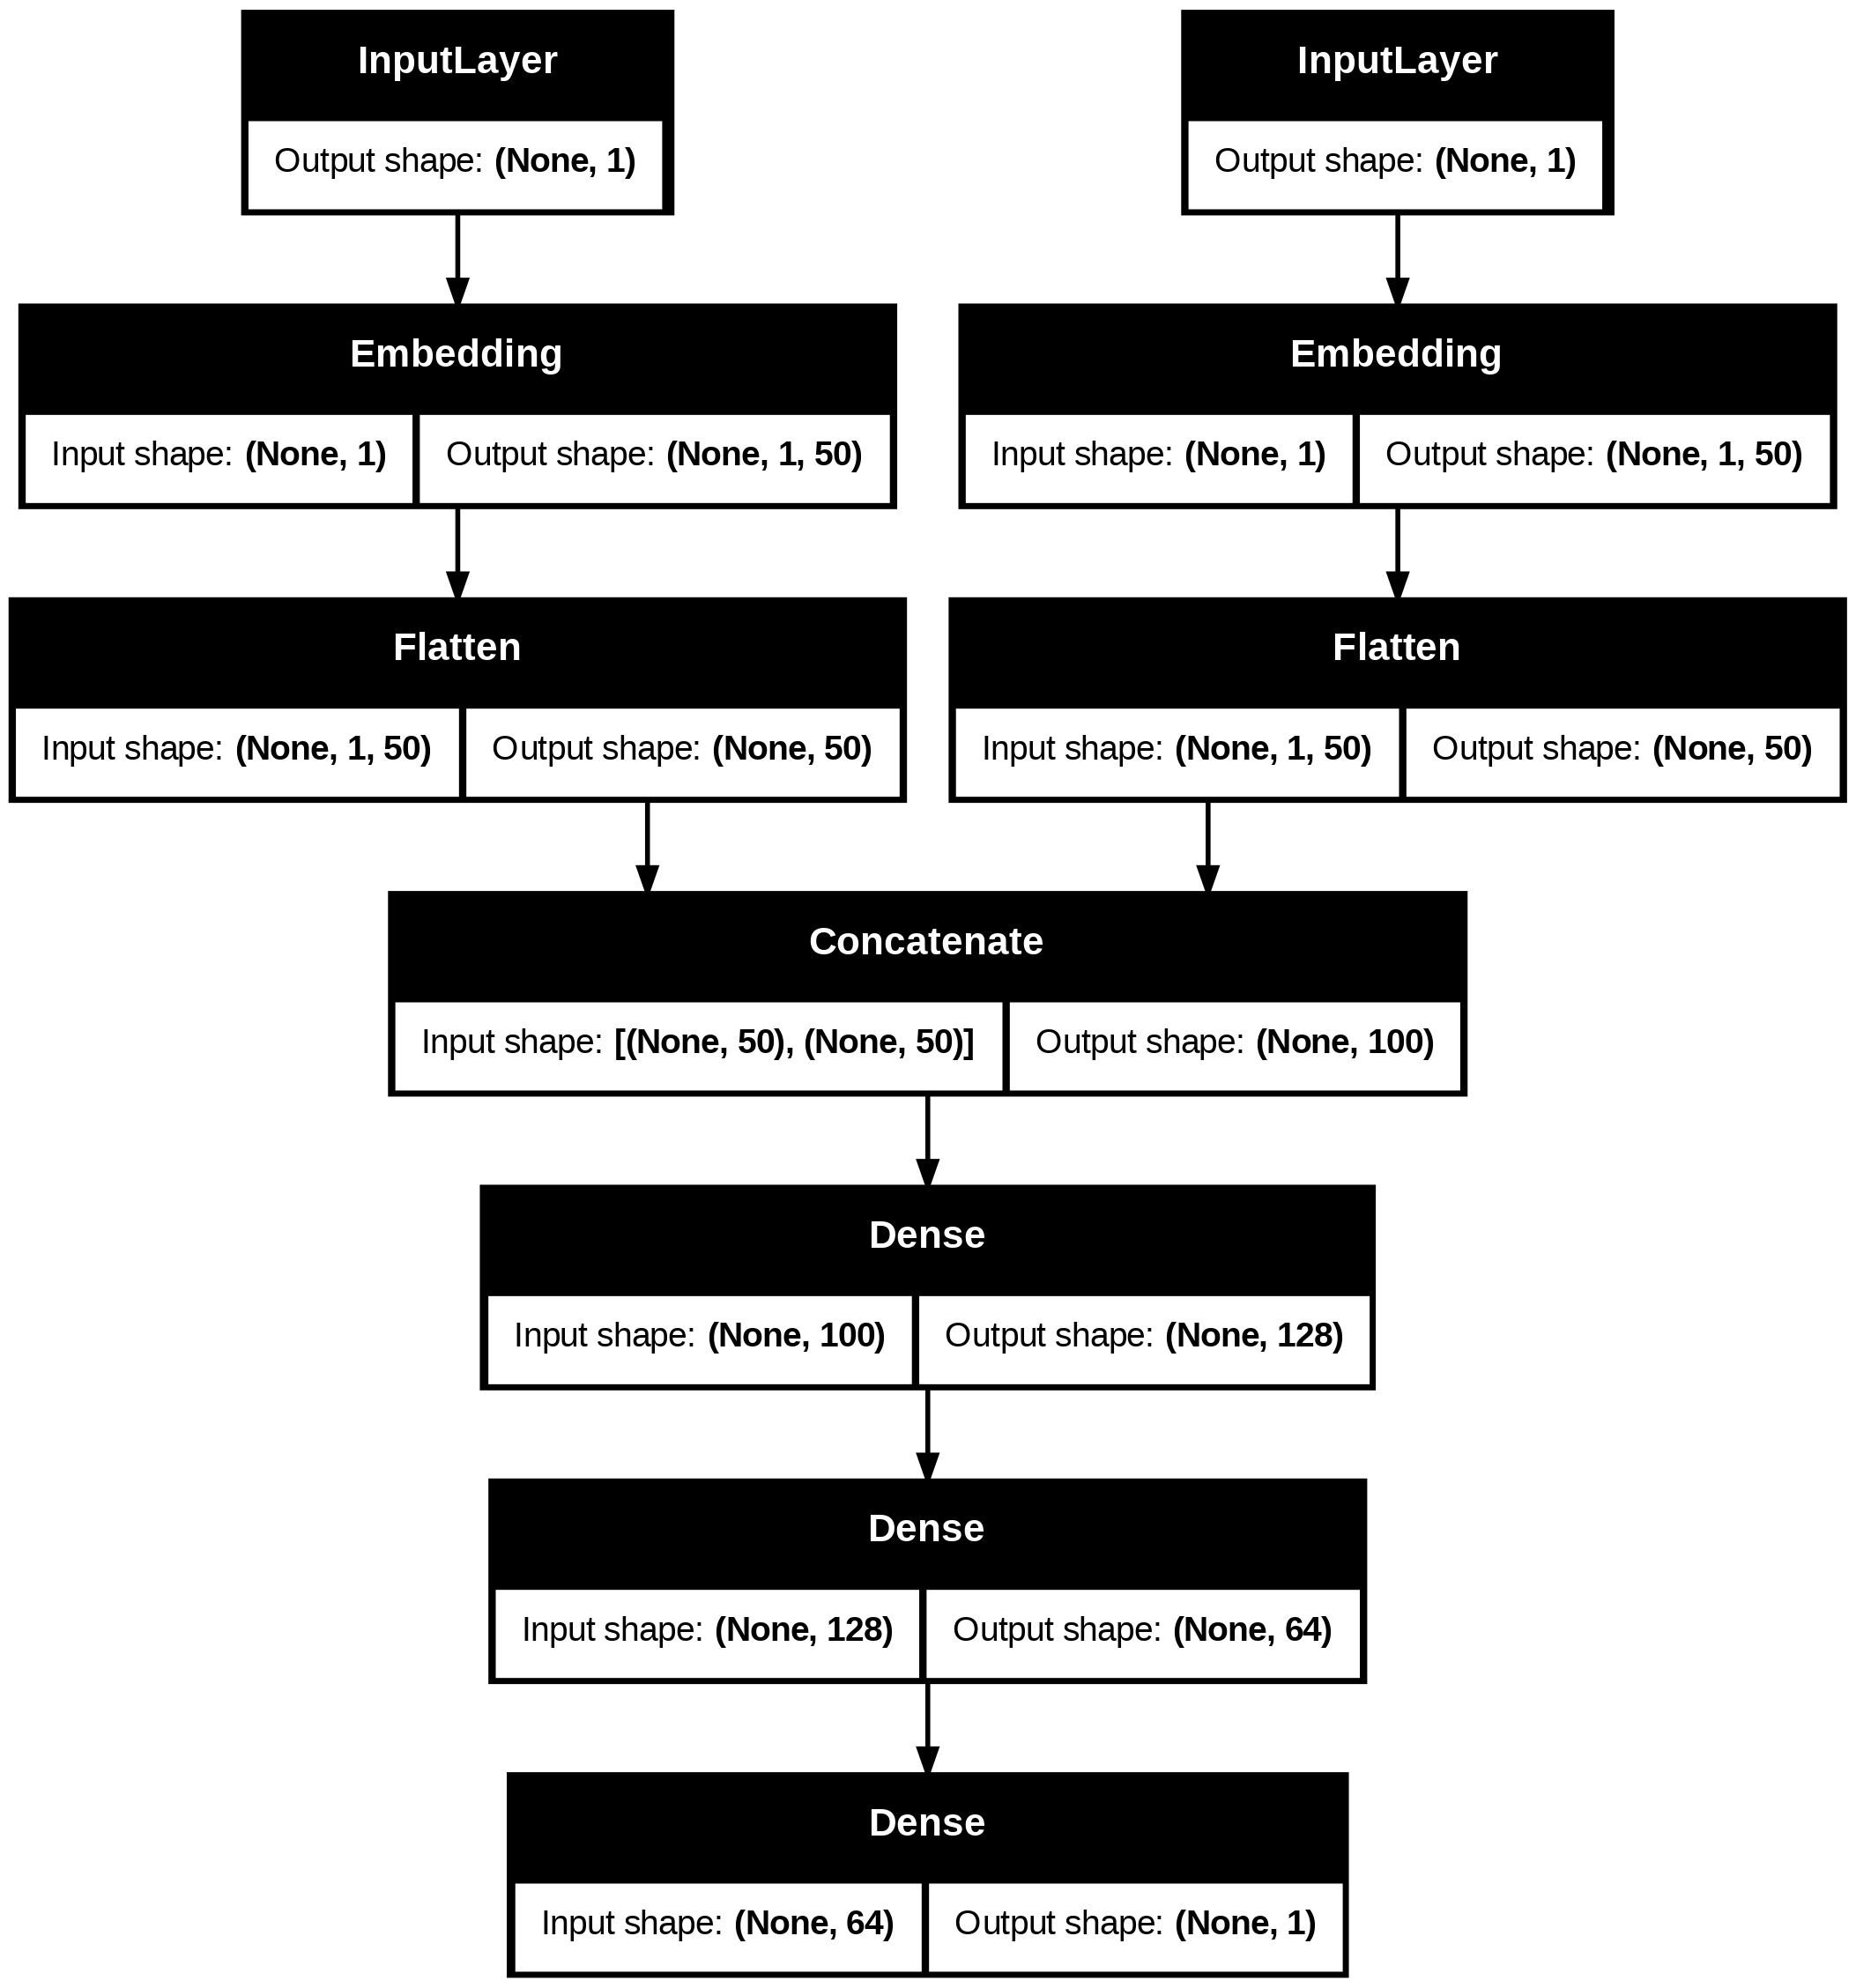

In [84]:
# Deciding on the embedding dimension
embedding_dim = 50

# User input and embedding layer
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_dim, name='user_embedding')(user_input)
user_vecs = Flatten()(user_embedding)

# Joke input and embedding layer
joke_input = Input(shape=(1,), name='joke_input')
joke_embedding = Embedding(input_dim=num_jokes, output_dim=embedding_dim, name='joke_embedding')(joke_input)
joke_vecs = Flatten()(joke_embedding)

# Concatenate user and joke vectors
input_vecs = Concatenate()([user_vecs, joke_vecs])

# Dense layers with relu function
dense = Dense(128, activation='relu')(input_vecs)
dense = Dense(64, activation='relu')(dense)
output = Dense(1, activation='linear')(dense)

# Compile model
model = Model(inputs=[user_input, joke_input], outputs=output)
model.compile(optimizer="Adam", loss='mean_squared_error')

# Print model summary
model.summary()

# Plot model
plot_model(model, to_file='model.png', show_shapes=True)

**Structure of the Neural Network**

1. Embedding Layers:
    *  User Embedding: Converts user id into dense vectors to capture user preferences
    *  Joke Embedding: Converst joke ids into dense vectors to capture joke characteristics
    *  We flatten both embedding to obtain a vector

2. Concatenation:
    *  Combines user and joke vectors into a singe vector

3. Dense Layers:
    *  We have 2 dense layers that helps to understand better each feature and uses ReLU activation function. Here, the key is that the number of neurons increases the complexity by combining some of the features and createing different combinations as new features. Hence, some feature engineering took place in this stage just like in our brains.
    *  Lastly the network gives output with shape 1 since it tries to predict the rating a user would give to a joke.

Here since data is large and we have 6 layers, we need to pick a large batch size to not to explode RAM.

In [92]:
# Prepare training data
train_user_data = train_data['user_id'].values
train_joke_data = train_data['joke_id'].values
train_ratings = train_data['rating'].values

# Train the model
history = model.fit(
    [train_user_data, train_joke_data],
    train_ratings,
    epochs=10,
    batch_size=512
)

Epoch 1/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 3.6617
Epoch 2/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 3.0919
Epoch 3/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.8273
Epoch 4/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.7076
Epoch 5/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.5987
Epoch 6/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.5163
Epoch 7/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.4510
Epoch 8/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 2.3902
Epoch 9/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 2.3359
Epoch 10/10
6464/6464 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2.2864


In [93]:
# Prepare testing data
test_user_data = test_data['user_id'].values
test_joke_data = test_data['joke_id'].values
test_ratings = test_data['rating'].values

# Make predictions
predictions = model.predict([test_user_data, test_joke_data])

# Calculate RMSE and MAE
rmse = np.sqrt(np.mean((predictions.flatten() - test_ratings) ** 2))
mae = np.mean(np.abs(predictions.flatten() - test_ratings))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

25853/25853 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step
RMSE: 5.312880255254157
MAE: 3.936428343355616


Now let's write the recommendation getter function. First we label encode the user ids and jokes.

In [97]:
from sklearn.preprocessing import LabelEncoder

# Assuming your dataset is in a DataFrame `rating_data`
user_encoder = LabelEncoder()
joke_encoder = LabelEncoder()

# Fit the encoders on the existing data
user_encoder.fit(rating_data['user_id'])
joke_encoder.fit(rating_data['joke_id'])

LabelEncoder()

Here the function takes a user id and tries to find any jokes that the user has not rated and will like. Then returns the number of recommendations amount of joke ids.

In [111]:
def recommend_jokes(user_id, num_recommendations=10):
    # Encode the user ID
    if user_id not in user_encoder.classes_:
        raise ValueError(f"User ID {user_id} not found in the dataset.")

    user_idx = user_encoder.transform([user_id])[0]

    # Get joke IDs the user has already rated
    rated_jokes = rating_data[rating_data['user_id'] == user_idx]['joke_id'].values

    # Get all joke IDs
    all_jokes = np.arange(len(joke_encoder.classes_))

    # Filter out the jokes the user has already rated
    unrated_jokes = np.setdiff1d(all_jokes, rated_jokes)

    if len(unrated_jokes) == 0:
        raise ValueError("No unrated jokes available for recommendations.")

    # Create arrays for user data and unrated jokes
    user_data = np.array([user_idx] * len(unrated_jokes)).reshape(-1, 1)
    unrated_jokes_data = unrated_jokes.reshape(-1, 1)

    # Predict ratings for the unrated jokes
    predicted_ratings = model.predict([user_data, unrated_jokes_data]).flatten()

    # Get the indices of the top N jokes with the highest predicted ratings
    top_joke_indices = np.argsort(predicted_ratings)[-num_recommendations:][::-1]

    # Get the actual joke IDs for the top recommendations
    recommended_jokes = joke_encoder.inverse_transform(unrated_jokes[top_joke_indices])

    return recommended_jokes

# Example: Get top 10 recommended jokes for a user
user_id = 12342
try:
    recommended_jokes = recommend_jokes(user_id, num_recommendations=10)
    print(f"Top 10 Recommended Jokes for User {user_id}: {recommended_jokes}")
except ValueError as e:
    print(e)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Top 10 Recommended Jokes for User 12342: [93 85 80 90 98 88 91 82 92 73]


Then we pass the joke ids to throw_an_another_joke function to actually reach the joke.

In [138]:
def throw_an_another_joke(user_id):
  recommended_jokes = recommend_jokes(user_id)
  return print(joke_text_df.loc[recommended_jokes[0]].values[0])

In [139]:
throw_an_another_joke(18219)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Q: How many Presidents does it take to screw in a light bulb?

A: It depends upon your definition of screwing a light bulb.



# Comparison

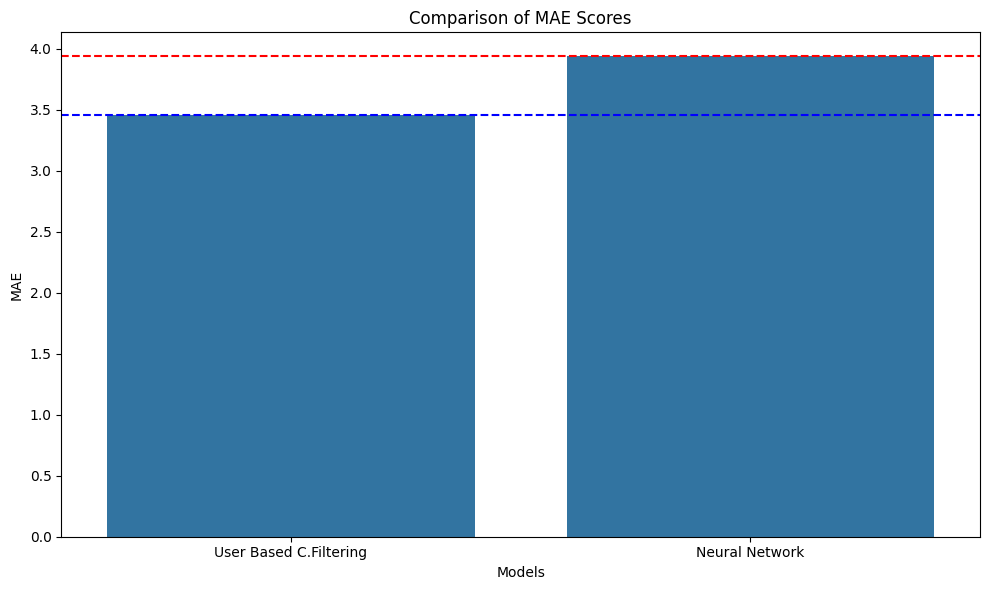

In [164]:
models = ["User Based C.Filtering","Neural Network"]
mae_scores = [svd_mae,mae]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=models, y=mae_scores, ax=ax)
ax.set_xlabel("Models")
ax.set_ylabel("MAE")
ax.set_title("Comparison of MAE Scores")
plt.tight_layout()
ax.axhline(y=mae, color='r', linestyle='--', label='Neural Network')
ax.axhline(y=svd_mae, color='b', linestyle='--', label='User Based C.Filtering')
plt.show()

## Conclusion and Insights

**Performance of Collaborative Filtering**
1. User-Based:
  * RMSE:4.5
  * MAE:3.45
  
  The user based collaborative filtering came out to be best. The reason behind this may be the high number of null values are affecting the neural network model worse. And also since the resources are finite, I was not able to train the neural network with more epochs and more layers which can close the gap between user based c. filtering and nn.
2. Item-Based
  
  On the other hand, since there were too many missing values and item based c. filtering is sensitive to missing values. I had to fill with 0. Hence high amount of 0s added to user item matrix increased the number of 0s and ultimately reduced the error in the test set since most of the predictions were near 0.


**Performance of TF IDF Model**
  
  I wish, I had better systems to run the prediction function for the test set and come up with an evaluation metric but I could not. Hence, the code is written and it works if time permits. So, i do not think I missed; faster CPU is needed at this point.

**Performance of Neural Network**
  * RMSE:5.31
  * MAE:3.93

  6-layered Neural Network also was a bit complex for such a sparse data. The reason behind not performing well may be the lack of parameter tuning for each layer and the selection of activation functions since there were too many 0s.

**Insights**
1. Model Comparison: SVD model performed best out of three models.

2. Use Case Suitability: For this case, the similarity of jokes are not that easy to catch. Hence TF-IDF models can be more suitable to movie or song type of cases rather than a case like this with too many different and bizarre words.
3. Scalability
Althogh there seems to be enough data, most of them are 0 after user 30k hence creates a bias between predicting for user 100 is much easier than 45989 which has almost half of the ratings null.


**Future Work**
1. Advanced Models: The Neural Network can be advanced with additional layers. Also clustering methods can be applied and used as a feature.
2. User feedback loop: With the addition of RL to the model, users can feedback and the model can keep improving itsel with every feedback.